# Seasonal Autoregressive Integrated Moving Average (SARIMA)

The <a href="https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average">ARIMA</a> model is a generalisation of an ARMA model that can be applied to non-stationary time series.

The SARIMA model is an modified version of ARIMA that accounts for seasonality in the time series.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

## Load Dataset

In [3]:
hec = pd.read_csv('../datasets/household-electricity.csv', parse_dates=[0])
print(hec.shape)
hec.head()

(26305, 322)


,DateTime,household_0,household_1,household_2,household_3,household_4,household_5,household_6,household_7,household_8,household_9,household_10,household_11,household_12,household_13,household_14,household_15,household_16,household_17,household_18,household_19,household_20,household_21,household_22,household_23,household_24,household_25,household_26,household_27,household_28,household_29,household_30,household_31,household_32,household_33,household_34,household_35,household_36,household_37,household_38,household_39,household_40,household_41,household_42,household_43,household_44,household_45,household_46,household_47,household_48,household_49,household_50,household_51,household_52,household_53,household_54,household_55,household_56,household_57,household_58,household_59,household_60,household_61,household_62,household_63,household_64,household_65,household_66,household_67,household_68,household_69,household_70,household_71,household_72,household_73,household_74,household_75,household_76,household_77,household_78,household_79,household_80,household_81,household_82,household_83,household_84,household_85,household_86,household_87,household_88,household_89,household_90,household_91,household_92,household_93,household_94,household_95,household_96,household_97,household_98,household_99,household_100,household_101,household_102,household_103,household_104,household_105,household_106,household_107,household_108,household_109,household_110,household_111,household_112,household_113,household_114,household_115,household_116,household_117,household_118,household_119,household_120,household_121,household_122,household_123,household_124,household_125,household_126,household_127,household_128,household_129,household_130,household_131,household_132,household_133,household_134,household_135,household_136,household_137,household_138,household_139,household_140,household_141,household_142,household_143,household_144,household_145,household_146,household_147,household_148,household_149,household_150,household_151,household_152,household_153,household_154,household_155,household_156,household_157,household_158,household_159,household_160,household_161,household_162,household_163,household_164,household_165,household_166,household_167,household_168,household_169,household_170,household_171,household_172,household_173,household_174,household_175,household_176,household_177,household_178,household_179,household_180,household_181,household_182,household_183,household_184,household_185,household_186,household_187,household_188,household_189,household_190,household_191,household_192,household_193,household_194,household_195,household_196,household_197,household_198,household_199,household_200,household_201,household_202,household_203,household_204,household_205,household_206,household_207,household_208,household_209,household_210,household_211,household_212,household_213,household_214,household_215,household_216,household_217,household_218,household_219,household_220,household_221,household_222,household_223,household_224,household_225,household_226,household_227,household_228,household_229,household_230,household_231,household_232,household_233,household_234,household_235,household_236,household_237,household_238,household_239,household_240,household_241,household_242,household_243,household_244,household_245,household_246,household_247,household_248,household_249,household_250,household_251,household_252,household_253,household_254,household_255,household_256,household_257,household_258,household_259,household_260,household_261,household_262,household_263,household_264,household_265,household_266,household_267,household_268,household_269,household_270,household_271,household_272,household_273,household_274,household_275,household_276,household_277,household_278,household_279,household_280,household_281,household_282,household_283,household_284,household_285,household_286,household_287,household_288,household_289,household_290,household_291,household_29

To keep training times reasonable, we'll only use the last 1000 rows of the dataset.

In [4]:
hec = hec.iloc[-1000:]

In [5]:
test_length = 500
train_length = len(hec) - test_length
three_weeks = 24*7*3

## Define Error Metrics

In [6]:
def calc_MASE(training_series, testing_series, prediction_series):
    n = len(training_series) - 1
    d = np.abs(np.diff(training_series)).sum()/ n
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d


def calc_sMASE(training_series, testing_series, prediction_series, seasonality=24):
    a = training_series.iloc[seasonality:].values
    b = training_series.iloc[:-seasonality].values
    d = np.sum(np.abs(a-b)) / len(a)
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

## Example ARIMAX Model

Exploration of how ARIMAX models work using a single example time series.

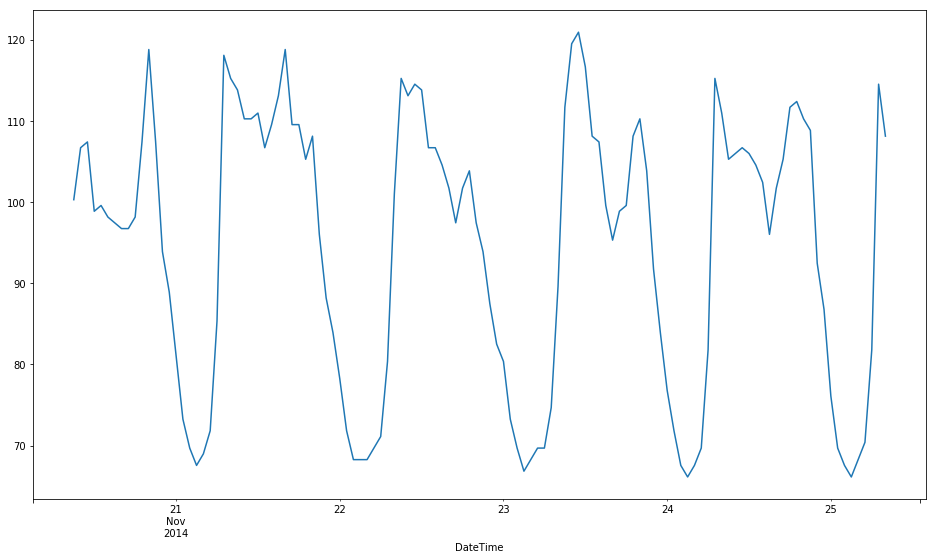

In [7]:
example_household = 'household_1'
df_ex = hec.set_index('DateTime').loc[:, example_household]

# Plot data from first five days
df_ex.iloc[:24*5].plot();

### Time Series Decomposition

Decompose the example time series into trend, seasonal, and residual components.

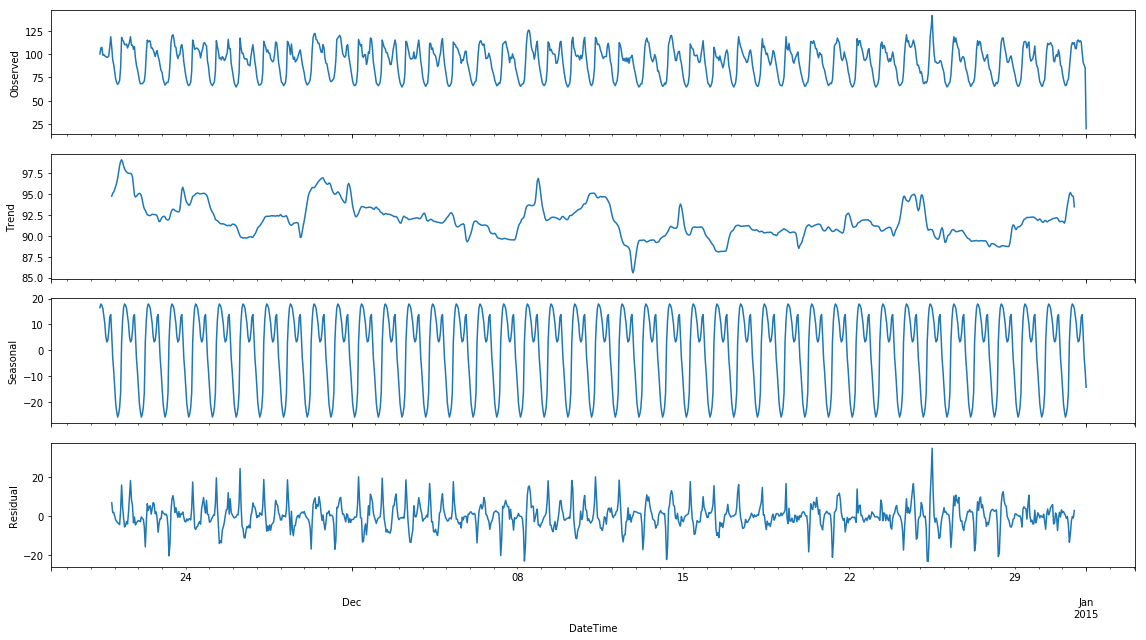

In [8]:
fig = seasonal_decompose(df_ex, model='additive').plot()

There doesn't appear to be a trend. We can run a Dicky-Fuller test to confirm the stationarity.

In [9]:
dftest = adfuller(df_ex, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -4.980469
p-value                          0.000024
#Lags Used                      22.000000
Number of Observations Used    977.000000
Critical Value (5%)             -2.864503
Critical Value (1%)             -3.437061
Critical Value (10%)            -2.568348
dtype: float64

The very low p-value confirms that the data is stationary. We can see that there is daily seasonality which we will capture in our SARIMA model.

### Plot ACF and PACF

The <a href="https://en.wikipedia.org/wiki/Autocorrelation">Autocorrelation Function</a> (ACF) is the correlation of a signal with a delayed copy of itself as a function of delay.

The <a href="https://en.wikipedia.org/wiki/Partial_autocorrelation_function">Partial Autocorrelation Function</a> (PACF) is the partial correlation of a signal with a delayed copy of itself, controlling for the values of the time series at all shorter delays, as a function of delay.

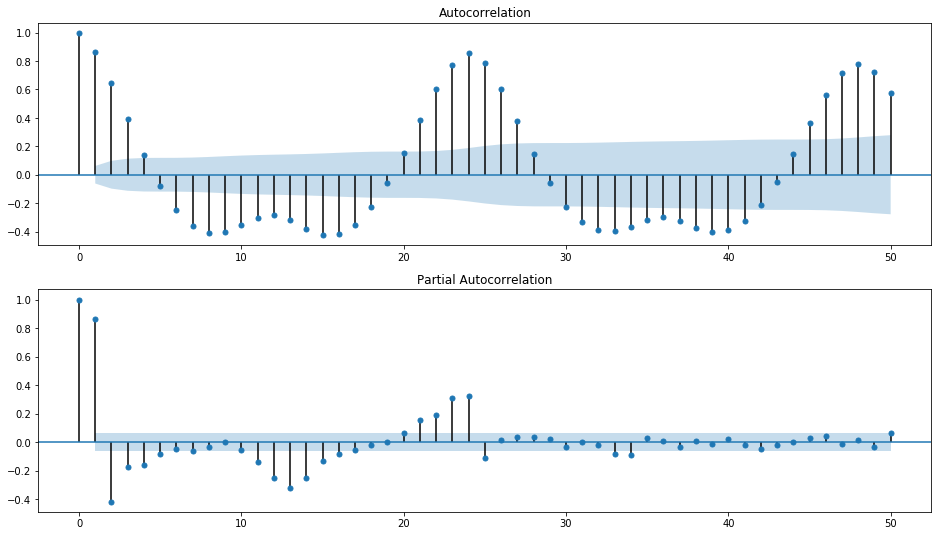

In [10]:
fig, ax = plt.subplots(2)
ax[0] = sm.graphics.tsa.plot_acf(df_ex, lags=50, ax=ax[0])
ax[1] = sm.graphics.tsa.plot_pacf(df_ex, lags=50, ax=ax[1])

There is clearly daily seasonality. We will use a seasonality of 24 hours in our SARIMA model. We can see that differencing by 24 hours helps remove the seasonality:

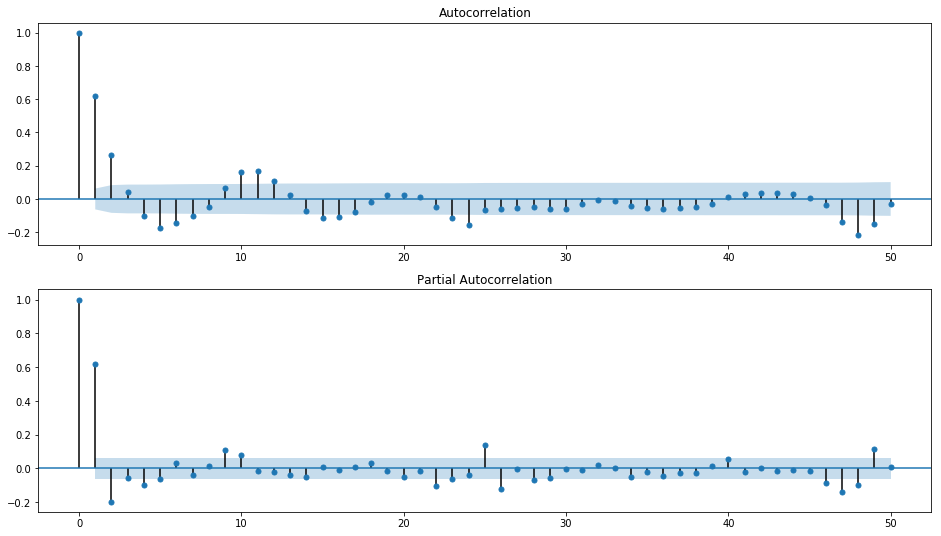

In [11]:
fig, ax = plt.subplots(2)
ax[0] = sm.graphics.tsa.plot_acf(df_ex.diff(24).dropna(), lags=50, ax=ax[0])
ax[1] = sm.graphics.tsa.plot_pacf(df_ex.diff(24).dropna(), lags=50, ax=ax[1])

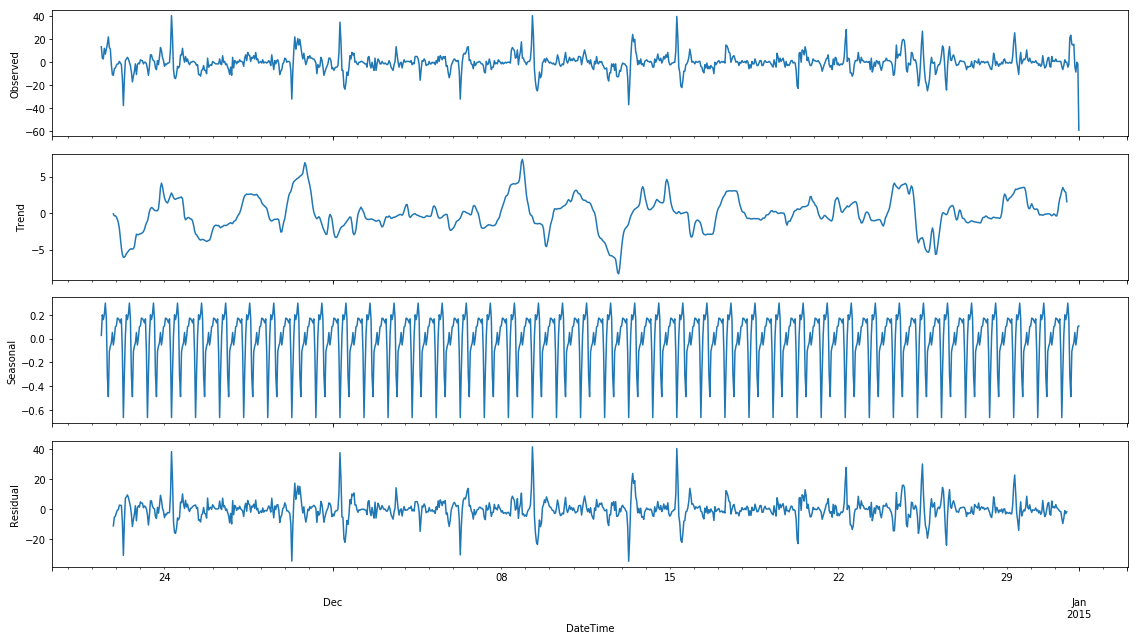

In [12]:
fig = seasonal_decompose(df_ex.diff(24).dropna(), model='additive').plot()

### Build Model

Given that SARIMA models can be slow to train, we will simply use a SARIMA(1,1,1)(1,1,1)24 model, as this should provide reasonable performance across the time series. If we wanted our forecasts to be more optimal, and we weren't concerned with training time, we could adopt a grid search methodology as demonstrated in the other time series forecasting techniques notebooks.

In [13]:
def runSARIMA(ts, test_length=test_length):
    ts_train = ts.iloc[:-test_length]
    ts_test = ts.iloc[-test_length:]
    
    sarima = sm.tsa.SARIMAX(ts_train, freq='H', order=(1,1,1),
                            seasonal_order=(1,1,1,24),
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit()
    
    summary = sarima.summary()

    fcst = sarima.predict(start=ts_train.index[2], end=ts_test.index[-1])
    fcst = np.concatenate([np.array([0, 0]), fcst])
    fcst = pd.DataFrame(data=fcst, index=ts.index, columns=['%s_pred' % ts.name])
    
    return fcst, summary  

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
%%time
fcst, summary = runSARIMA(df_ex)
df_ex = pd.concat([df_ex, fcst], axis=1)
print(summary)

                                 Statespace Model Results                                 
Dep. Variable:                        household_1   No. Observations:                  500
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -1370.101
Date:                            Tue, 04 Sep 2018   AIC                           2750.201
Time:                                    21:32:32   BIC                           2770.736
Sample:                                11-20-2014   HQIC                          2758.296
                                     - 12-11-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6701      0.033     20.365      0.000       0.606       0.735
ma.L1         -1.0000     42.156   

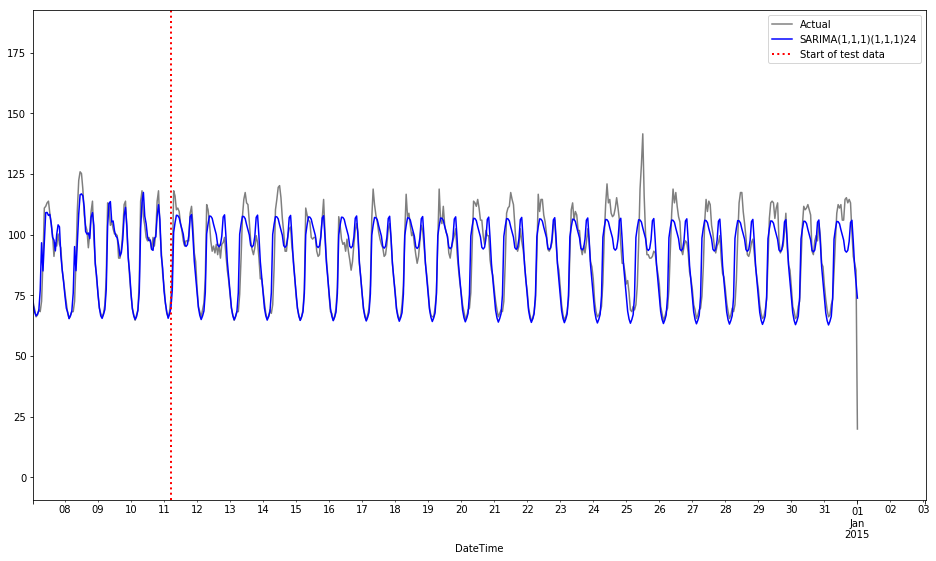

In [16]:
# Example forecast
fcst0 = df_ex.copy()
fcst0['%s_pred' % example_household][fcst0['%s_pred' % example_household] < 0] = 0

fcst0[example_household].plot(label='Actual', c='k', alpha=0.5)
fcst0['%s_pred' % example_household].plot(label='SARIMA(1,1,1)(1,1,1)24', c='b')
plt.axvline(x=fcst0.index[-test_length], linestyle=':', linewidth=2, color='r', label='Start of test data')
plt.legend()
plt.xlim(fcst0.index[400]);

## Evaluating SARIMA

To evaluate SARIMA, we will generate forecasts for each time series using the SARIMA(1,1,1)(1,1,1)24 approach shown above. MASE and sMASE will be calculated for each individual time series, and the mean of all these scores will be used as overall accuracy metrics for SARIMA on this dataset.

In [17]:
results = hec.copy()
results['training'] = 0
results['training'][:-test_length] = 1

tic = time()
for i, col in enumerate(hec.columns[1:]):
    if i % 10 == 0:
        toc = time()
        print("Running predictions for {}. Cumulative time: {:.1f} minutes.".format(col, (toc-tic)/60))
        
    # Prepare DataFrame for selected column
    df = hec.set_index('DateTime').loc[:, col]
    
    # Find best model
    fcst, summary = runSARIMA(df)
    # Add predictions to results DataFrame
    results['%s_pred' % col] = fcst.values

toc = time()
print("Finished! Total run time: {:.1f} minutes.".format((toc-tic)/60))

Running predictions for household_0. Cumulative time: 0.0 minutes.
Running predictions for household_10. Cumulative time: 1.9 minutes.
Running predictions for household_20. Cumulative time: 4.0 minutes.
Running predictions for household_30. Cumulative time: 5.9 minutes.
Running predictions for household_40. Cumulative time: 7.6 minutes.
Running predictions for household_50. Cumulative time: 9.5 minutes.
Running predictions for household_60. Cumulative time: 11.3 minutes.
Running predictions for household_70. Cumulative time: 13.3 minutes.
Running predictions for household_80. Cumulative time: 15.1 minutes.
Running predictions for household_90. Cumulative time: 16.9 minutes.
Running predictions for household_100. Cumulative time: 18.8 minutes.
Running predictions for household_110. Cumulative time: 20.6 minutes.
Running predictions for household_120. Cumulative time: 22.3 minutes.
Running predictions for household_130. Cumulative time: 24.0 minutes.
Running predictions for household_140

In [18]:
results.head()

,DateTime,household_0,household_1,household_2,household_3,household_4,household_5,household_6,household_7,household_8,household_9,household_10,household_11,household_12,household_13,household_14,household_15,household_16,household_17,household_18,household_19,household_20,household_21,household_22,household_23,household_24,household_25,household_26,household_27,household_28,household_29,household_30,household_31,household_32,household_33,household_34,household_35,household_36,household_37,household_38,household_39,household_40,household_41,household_42,household_43,household_44,household_45,household_46,household_47,household_48,household_49,household_50,household_51,household_52,household_53,household_54,household_55,household_56,household_57,household_58,household_59,household_60,household_61,household_62,household_63,household_64,household_65,household_66,household_67,household_68,household_69,household_70,household_71,household_72,household_73,household_74,household_75,household_76,household_77,household_78,household_79,household_80,household_81,household_82,household_83,household_84,household_85,household_86,household_87,household_88,household_89,household_90,household_91,household_92,household_93,household_94,household_95,household_96,household_97,household_98,household_99,household_100,household_101,household_102,household_103,household_104,household_105,household_106,household_107,household_108,household_109,household_110,household_111,household_112,household_113,household_114,household_115,household_116,household_117,household_118,household_119,household_120,household_121,household_122,household_123,household_124,household_125,household_126,household_127,household_128,household_129,household_130,household_131,household_132,household_133,household_134,household_135,household_136,household_137,household_138,household_139,household_140,household_141,household_142,household_143,household_144,household_145,household_146,household_147,household_148,household_149,household_150,household_151,household_152,household_153,household_154,household_155,household_156,household_157,household_158,household_159,household_160,household_161,household_162,household_163,household_164,household_165,household_166,household_167,household_168,household_169,household_170,household_171,household_172,household_173,household_174,household_175,household_176,household_177,household_178,household_179,household_180,household_181,household_182,household_183,household_184,household_185,household_186,household_187,household_188,household_189,household_190,household_191,household_192,household_193,household_194,household_195,household_196,household_197,household_198,household_199,household_200,household_201,household_202,household_203,household_204,household_205,household_206,household_207,household_208,household_209,household_210,household_211,household_212,household_213,household_214,household_215,household_216,household_217,household_218,household_219,household_220,household_221,household_222,household_223,household_224,household_225,household_226,household_227,household_228,household_229,household_230,household_231,household_232,household_233,household_234,household_235,household_236,household_237,household_238,household_239,household_240,household_241,household_242,household_243,household_244,household_245,household_246,household_247,household_248,household_249,household_250,household_251,household_252,household_253,household_254,household_255,household_256,household_257,household_258,household_259,household_260,household_261,household_262,household_263,household_264,household_265,household_266,household_267,household_268,household_269,household_270,household_271,household_272,household_273,household_274,household_275,household_276,household_277,household_278,household_279,household_280,household_281,household_282,household_283,household_284,household_285,household_286,household_287,household_288,household_289,household_290,household_291,household_29

In [19]:
results0 = results.iloc[:, 1:].copy()
results0[results0 < 0] = 0
results0['DateTime'] = results['DateTime']

In [20]:
MASEs = []
sMASEs = []
for col in hec.columns[1:]:
    MASEs.append(calc_MASE(results0[col].iloc[-(test_length+three_weeks):-test_length],
                           results0[col].iloc[-test_length:],
                           results0['%s_pred' % col].iloc[-test_length:]))
    sMASEs.append(calc_sMASE(results0[col].iloc[-(test_length+three_weeks):-test_length],
                             results0[col].iloc[-test_length:],
                             results0['%s_pred' % col].iloc[-test_length:]))

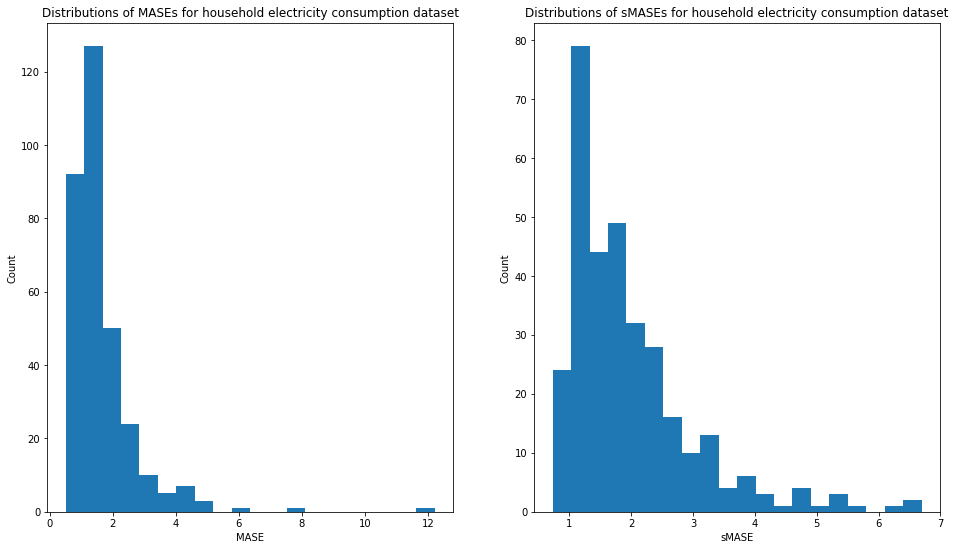

In [21]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(MASEs, bins=20)
ax[0].set_title('Distributions of MASEs for household electricity consumption dataset')
ax[0].set_xlabel('MASE')
ax[0].set_ylabel('Count')
ax[1].hist(sMASEs, bins=20)
ax[1].set_title('Distributions of sMASEs for household electricity consumption dataset')
ax[1].set_xlabel('sMASE')
ax[1].set_ylabel('Count');

In [22]:
MASE = np.mean(MASEs)
sMASE = np.mean(sMASEs)
print("Overall MASE: {:.4f}".format(MASE))
print("Overall sMASE: {:.4f}".format(sMASE))

Overall MASE: 1.6754
Overall sMASE: 1.9686


Show some example forecasts.

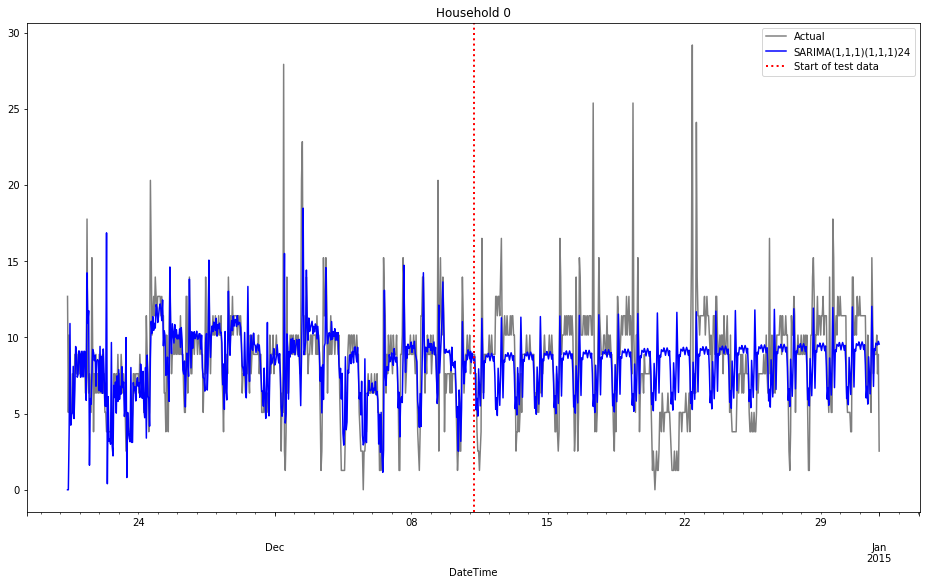

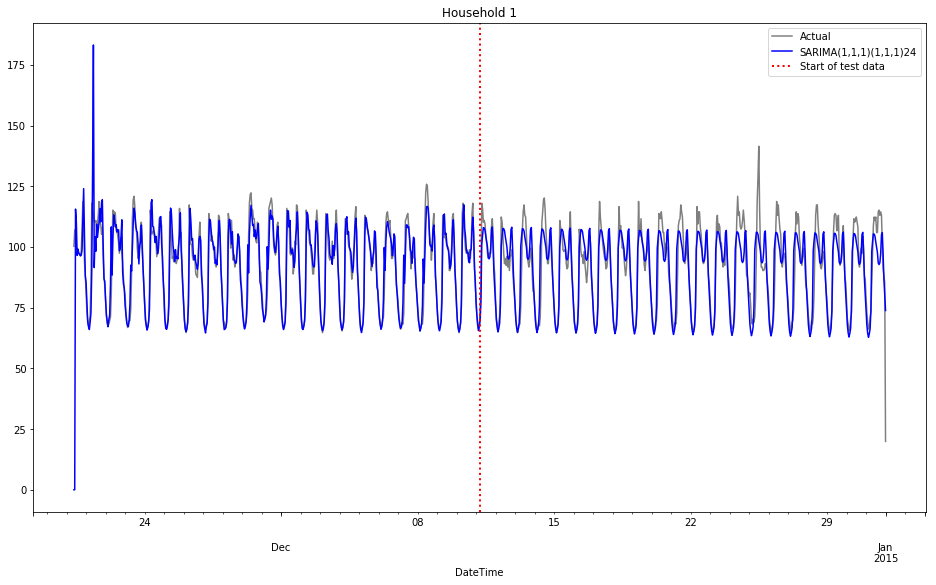

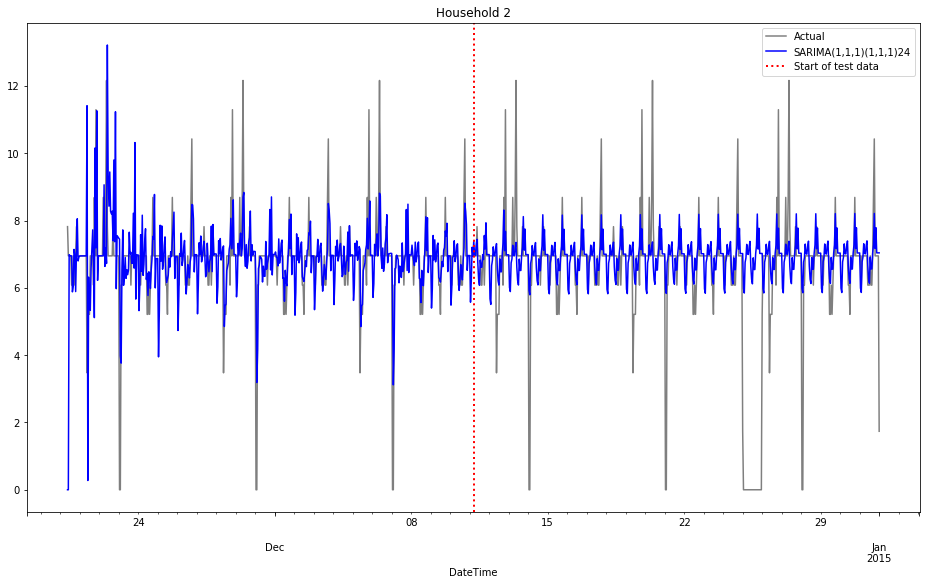

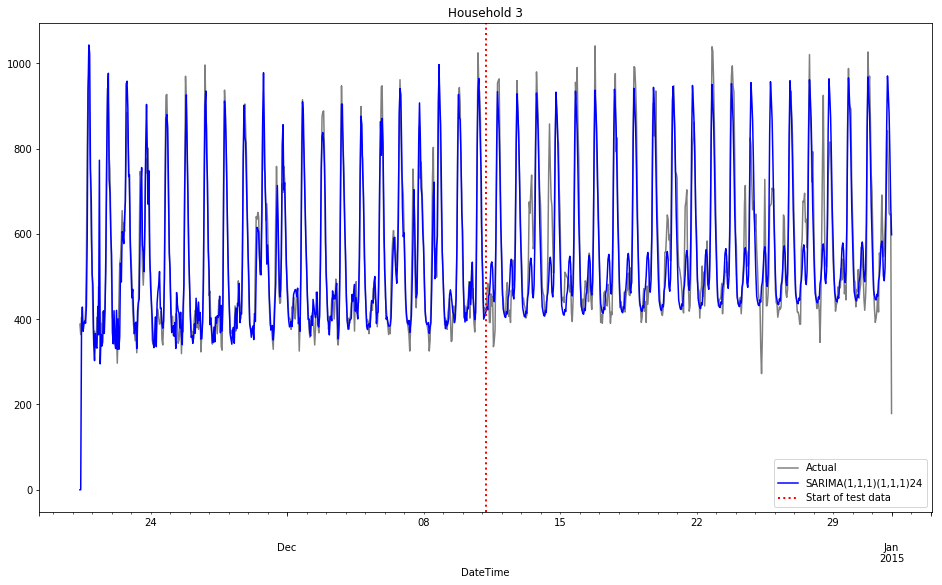

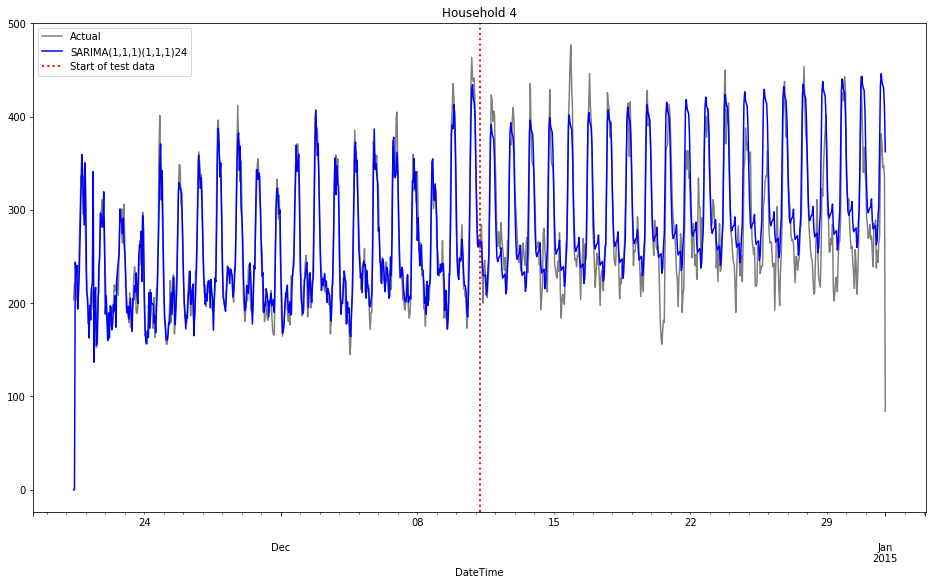

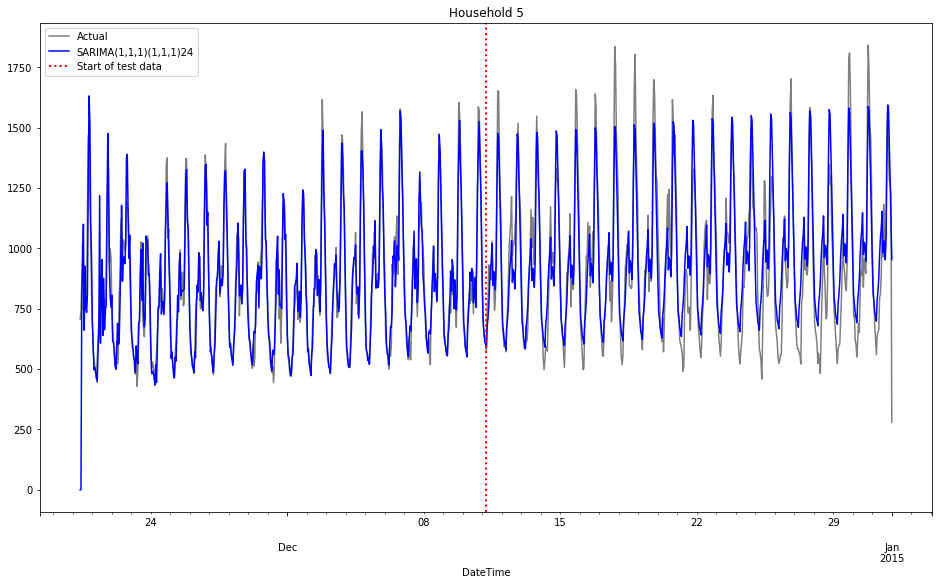

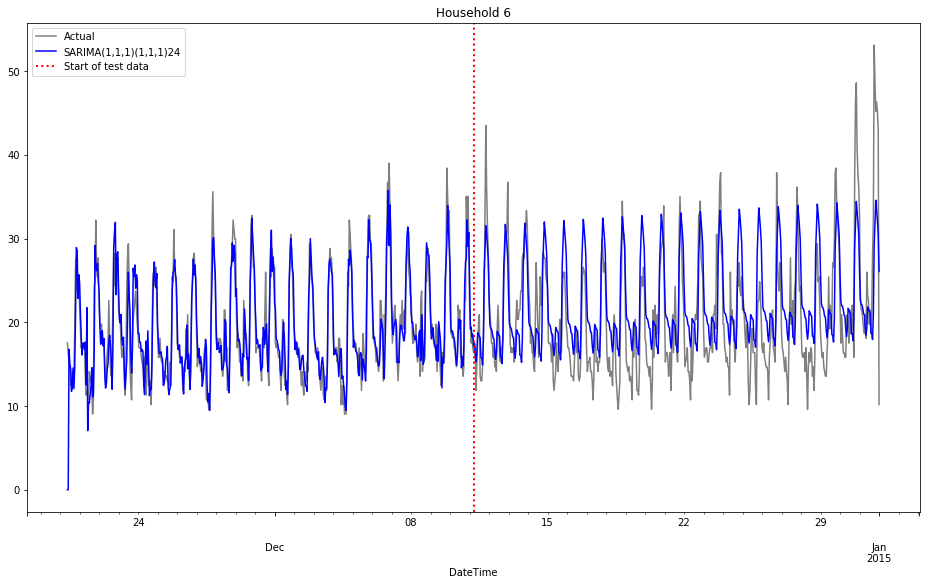

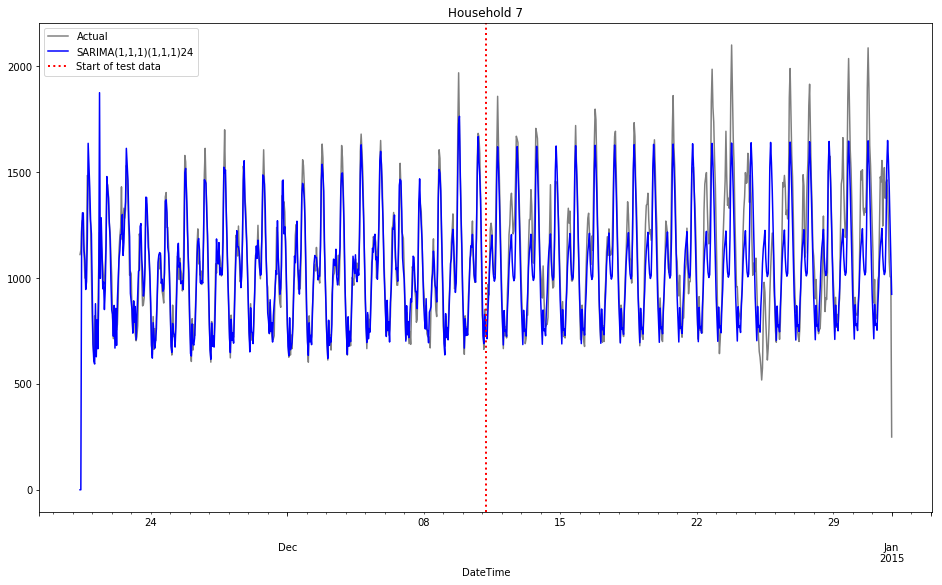

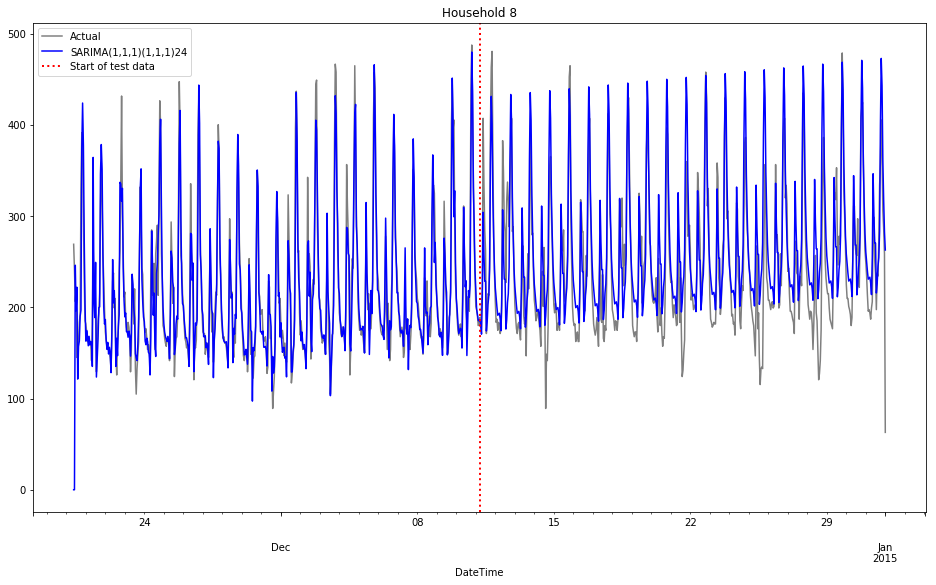

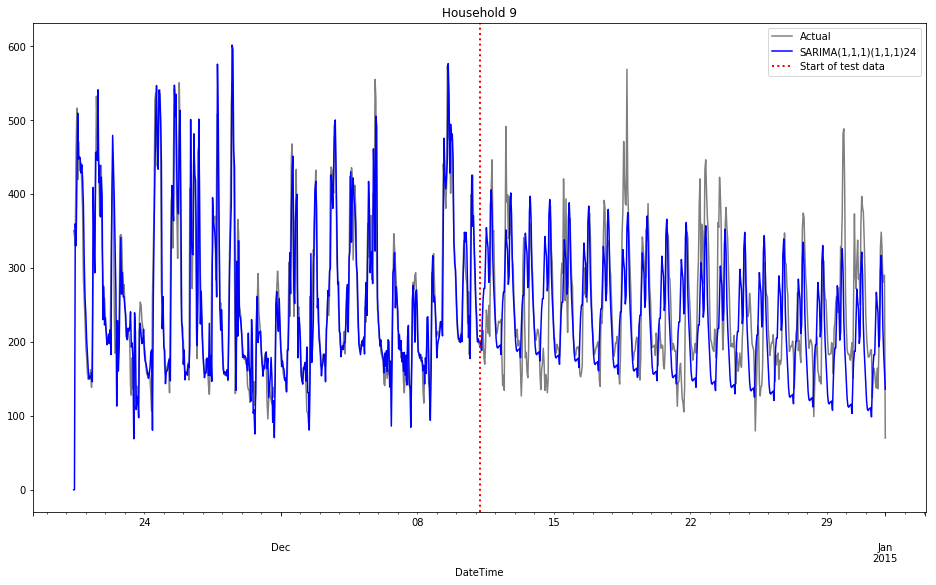

In [26]:
results_d = results0.set_index('DateTime')

for house in range(0, 10):
    results_d['household_%s' % house].plot(label='Actual', c='k', alpha=0.5)
    results_d['household_%s_pred' % house].plot(label='SARIMA(1,1,1)(1,1,1)24', c='b')
    plt.axvline(x=results_d.index[-test_length], linestyle=':', linewidth=2, color='r', label='Start of test data')
    plt.legend()
    plt.title('Household %s' % house)
    plt.show();

Store the accuracy scores for the SARIMA models.

In [27]:
import pickle
  
with open('hec-MASE.pkl', 'wb') as f:
    pickle.dump(MASE, f)
    
with open('hec-sMASE.pkl', 'wb') as f:
    pickle.dump(sMASE, f)

Store the predictions and parameters.

In [28]:
with open('../_results/SARIMA/hec-results.pkl', 'wb') as f:
    pickle.dump(results0, f)